## Creates the Outflow Graph

In [5]:
import os
import json
import requests
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
def start_end_time():
    endTime = datetime.datetime.now()
    startTime = endTime - datetime.timedelta(30)

    endTime = str(int(endTime.timestamp()))
    startTime = str(int(startTime.timestamp()))
    return startTime, endTime

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception:
        print(response)
        return None
    
def reindex(data, index):
    """ Returns the DataFrame calculated w/ inflow & outflow
    :type data: DataFrame
    :type index: List[int]
    :rtype: DataFrame
    """
    d = np.digitize(data.timestamp.values, index)
    g = data[["inflow", "outflow"]].groupby(d).sum()
    g = g.reindex(range(24*30), fill_value=0)
    g.index = index
    return g

def inflow_outflow(data: dict):
    "Returns the inflow and outflow of the payload"
    # get the column names
    columns = data["metadata"]["columns"]
    # load the data, dropping timestampNano
    ad_hist = pd.DataFrame(data["data"], columns=columns).drop("timestampNanoseconds", axis=1)
    # change dtype of appropriate columns to Int
    ad_hist[["blockNumber", "timestamp", "value"]] = ad_hist[["blockNumber", "timestamp", "value"]].apply(pd.to_numeric)
    # sort by blockNum desc
    ad_hist = ad_hist.sort_values("timestamp").reset_index(drop=True)
    # calculate inflow and outflow
    ad_hist["diff"] = ad_hist["value"].diff()
    ad_hist["inflow"] = np.where(ad_hist["diff"] > 0, ad_hist["diff"], 0)
    ad_hist["outflow"] = np.where(ad_hist["diff"] < 0, abs(ad_hist["diff"]), 0)
    # return the result
    return ad_hist
    
def daily_inflow_outflow(address, headers, querystring):
    url = "https://web3api.io/api/v2/addresses/" + address + "/account-balances/historical"
    try:
        payload = get_response(url=url, headers=headers, queryString=querystring)
    except Exception:
        return None
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        return g

In [7]:
startTime, endTime = start_end_time()
index = [10**3*(int(startTime) + i*60**2) for i in range(24*30)]

querystring = {"startDate": startTime,
               "endDate": endTime
              }

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': os.getenv("AMBERDATA_API_KEY")
}

df = pd.read_csv("../input/addresses_all.csv")
# check if we are running the full calculation
addresses = df.Address.values

In [8]:
activ = []
i = 0

while len(activ) < 30:
    url = "https://web3api.io/api/v2/addresses/" + addresses[i] + "/account-balances/historical"
    try:
        payload = get_response(url=url, headers=headers, queryString=querystring)
    except Exception:
        pass
    i += 1
    if len(payload["data"]) > 1:   # if there is activity in the period
        # calculate inflow / outflow
        data = inflow_outflow(payload)
        # get in the format to merge with master inflow/outflow data
        g = reindex(data, index)
        g.index = [datetime.datetime.fromtimestamp(i//10**3) for i in g.index.values]
        activ.append(g)

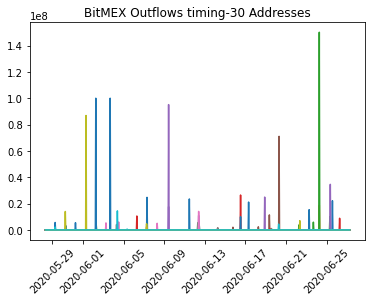

In [11]:
N = 30
data = [i.outflow for i in activ[:N]]

for i in range(len(data)):
    plt.plot(data[i])
    
plt.title(f"BitMEX Outflows timing-{N} Addresses")
plt.xticks(rotation=45)
plt.savefig("../plots/btc_outflow.png", bbox_inches="tight")

In [60]:
# code inspired by http://blog.josephmisiti.com/group-by-datetimes-in-pandas
# load in the inflow data, rename columns
combined = pd.DataFrame(data).T
combined.columns = [str(i) for i in range(N)]
# simply indicate if outflow > 0
combined = combined.applymap(lambda x: 1 if x > 0 else 0)
# bring index to a column
combined = combined.reset_index().rename({"index": "ts"}, axis=1)
# making date column from timestamp
combined['date'] = combined["ts"].apply(lambda df: datetime.datetime(year=df.year, month=df.month, day=df.day)) 
# make dates the index
combined.set_index(combined["date"],inplace=True)
# dropping unused date and timestamp columns
combined = combined.drop(["date", "ts"], axis=1)
# group by days
combined = combined.resample('D').sum()
# test our assumption of 1 outflow per day
if combined.max(axis=1).max() == 1:
    print("Our assumtion is safe.")
else:
    print("Incorrect assumption!")

Our assumtion is safe.
